# Problem
### Classifying the pages as "Ephemeral" or "Evergreen".
#### The Dependent variable is Label Column
#### Classification using Logistic Regression

# Approach

In the Dataset, the important columns are urlid, boilerplate, label. In the Column Boilerplate each row is in JSON Format and consists of the Title of the page and the Body of the page, So as it is an important Column to classify the pages. So I converted that Column into a DataFrame. The DataFrame consists of 4 Columns namely, URLId, Title, Body and Label from the Train Data. The Column urlid refers to the id of the URl of each row so i used it in the dataframe, so that each title and body could be mapped to that paticular url referred by the ID.

As we know that Label is a Dependent variable i assigned it to a variable 'y'. Then i used word tokenizer to split the sentence into words for both train data and test data. I then reduced those words after tokenizing into their stem words using PorterStemmer. As i got the stemmed words i converted those text into Feature Vectors using TfidfVectorizer. I converted those Feature Vectors into Sparse Matrix and called Logistic Regression to classify the Page as "Ephemeral" or "Evergreen".

# Import Packages

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

# Reading and Displaying the Dataset

In [154]:
train_data=pd.read_csv('train.tsv',delimiter='\t')
test_data=pd.read_csv('test.tsv',delimiter='\t')

In [155]:
train_data.head(2)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1


In [156]:
test_data.head(2)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,...,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,...,0.080000,?,1,62,0,382,39,2,0.128205,0.176471


# Data Munging or Data Preparation

In [157]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                7395 non-null   object 
 4   alchemy_category_score          7395 non-null   object 
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

In [158]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             3171 non-null   object 
 1   urlid                           3171 non-null   int64  
 2   boilerplate                     3171 non-null   object 
 3   alchemy_category                3171 non-null   object 
 4   alchemy_category_score          3171 non-null   object 
 5   avglinksize                     3171 non-null   float64
 6   commonlinkratio_1               3171 non-null   float64
 7   commonlinkratio_2               3171 non-null   float64
 8   commonlinkratio_3               3171 non-null   float64
 9   commonlinkratio_4               3171 non-null   float64
 10  compression_ratio               3171 non-null   float64
 11  embed_ratio                     3171 non-null   float64
 12  framebased                      31

In [159]:
train_data.duplicated().sum()

0

In [160]:
test_data.duplicated().sum()

0

In [161]:
urlid = train_data["urlid"]

# Converting the JSON into a Data Frame

In [162]:
title = []
body = []
urlid = []
label = []

for i in range(7395):
    X=json.loads(train_data["boilerplate"][i])
    if 'title' in X.keys() and 'body' in X.keys():
        title.append(X.get('title'))
        body.append(X.get('body'))
        urlid.append(train_data['urlid'][i])
        label.append(train_data['label'][i])
    

trainboilerplate = {'urlid':urlid,'title':title,'body':body,'label':label}
newTrainBoilerPlate = pd.DataFrame.from_dict(trainboilerplate) 

In [163]:
newTrainBoilerPlate.head(15)

,urlid,title,body,label
0,4042,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,0
1,8471,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,1
2,1164,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,1
3,6684,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,1
4,9006,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,0
5,7018,Genital Herpes Treatment,Genital herpes is caused by herpes simplex vir...,0
6,8685,fashion lane American Wild Child,Our favorite summer holiday is just around the...,1
7,3402,Racing For Recovery by Dean Johnson racing for...,Racing For Recovery is the growing idea that d...,0
8,477,Valet The Handbook 31 Days 31 days,Resolutions are for suckers Instead of swearin...,1
9,6731,Cookies and Cream Brownies How Sweet It Is,More brownies It seems that I can t get throug...,1


In [164]:
newTrainBoilerPlate.isna().sum()

urlid     0
title    12
body     57
label     0
dtype: int64

In [165]:
newTrainBoilerPlate = newTrainBoilerPlate.fillna(method='ffill')

In [166]:
newTrainBoilerPlate.isna().sum()

urlid    0
title    0
body     0
label    0
dtype: int64

In [167]:
newTrainBoilerPlate.shape

(7394, 4)

In [168]:
newTrainBoilerPlate.head(20)

,urlid,title,body,label
0,4042,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,0
1,8471,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,1
2,1164,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,1
3,6684,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,1
4,9006,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,0
5,7018,Genital Herpes Treatment,Genital herpes is caused by herpes simplex vir...,0
6,8685,fashion lane American Wild Child,Our favorite summer holiday is just around the...,1
7,3402,Racing For Recovery by Dean Johnson racing for...,Racing For Recovery is the growing idea that d...,0
8,477,Valet The Handbook 31 Days 31 days,Resolutions are for suckers Instead of swearin...,1
9,6731,Cookies and Cream Brownies How Sweet It Is,More brownies It seems that I can t get throug...,1


In [169]:
title=[]
body=[]
urlid=[]
label=[]

for i in range(3171):
    X=json.loads(test_data["boilerplate"][i])
    if 'title' in X.keys() and 'body' in X.keys():
        title.append(X.get('title'))
        body.append(X.get('body'))
        urlid.append(test_data['urlid'][i])
        
    

testBoilerPlate = {'urlid':urlid,'title':title,'body':body}
newTestBoilerPlate = pd.DataFrame.from_dict(testBoilerPlate) 

In [170]:
newTestBoilerPlate.isna().sum()

urlid     0
title     5
body     20
dtype: int64

In [171]:
newTestBoilerPlate = newTestBoilerPlate.fillna(method='ffill')

In [172]:
for i in range(7393):
  if newTrainBoilerPlate['body'][i] is  None :
          newTrainBoilerPlate.drop(index=i,inplace=True)
  elif len(newTrainBoilerPlate['body'][i]) < 20:
          newTrainBoilerPlate.drop(index=i,inplace=True)
newTrainBoilerPlate.reset_index(inplace=True)   

In [173]:
newTrainBoilerPlate.drop(columns=['index'],inplace=True)
newTrainBoilerPlate

,urlid,title,body,label
0,4042,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,0
1,8471,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,1
2,1164,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,1
3,6684,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,1
4,9006,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,0
...,...,...,...,...
6736,8923,Gummy Snake Worth1000 Contests,Entry Details Entered 12 1 2008 12 08 35 PM Ra...,0
6737,8958,Kno Raises 46 Million More To Build Most Power...,Marc Andreessen is normally enthusiastic about...,0
6738,8895,Why I Miss College,Mar 30 2009 I d like to congratulate Jane on h...,0
6739,1191,Sweet Potatoes Eat This Not That i'm eating t...,They re loaded with vitamin C which smoothes o...,1


In [174]:
y = newTrainBoilerPlate['label']

In [175]:
nltk.download('stopwords')
nltk.download('punkt')
ps=PorterStemmer()
data=newTrainBoilerPlate.iloc[:,1:3]
data.replace("[^a-zA-Z]"," ",regex=True,inplace=True)
data['title']=data['title'].str.lower()
data['body']=data['body'].str.lower()
data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,body
0,ibm sees holographic calls air breathing batte...,a sign stands outside the international busine...
1,the fully electronic futuristic starting gun t...,and that can be carried on a plane without the...
2,fruits that fight the flu fruits that fight th...,apples the most popular source of antioxidants...
3,foolproof tips for better sleep,there was a period in my life when i had a lot...
4,the coolest jerseys you didn t know existed...,jersey sales is a curious business whether you...
...,...,...
6736,gummy snake worth contests,entry details entered pm ra...
6737,kno raises million more to build most power...,marc andreessen is normally enthusiastic about...
6738,why i miss college,mar i d like to congratulate jane on h...
6739,sweet potatoes eat this not that i m eating t...,they re loaded with vitamin c which smoothes o...


In [176]:
titlebodycombined_train=[]
titlebodycombined_test=[]
for row in range(0,len(data.index)):
    titlebodycombined_train.append(' '.join(str(x) for x in data.iloc[row,1:3]))


for row in range(0,len(newTestBoilerPlate.index)):
    titlebodycombined_test.append(' '.join(str(x) for x in newTestBoilerPlate.iloc[row,1:3]))
titlebodycombined_test[0] 

'Homemade Enchilada Sauce Lynn s Kitchen Adventures  I usually buy my enchilada sauce Yes I knew I should be making it but I had never found a recipe that I was really happy with I had tried several and they just weren t very good So I stuck to the canned stuff you can get at the grocery store I was recently talking to a friend of mine about this She lived in Mexico for a few years so she knows some about Mexican cooking I asked her how she made her enchilada sauce She told me the basics and then gave me an exact recipe I decided to give it a try This recipe was really good This was the best enchilada sauce that I have made It had great flavor I think it was even better than the canned sauce My husband thought it could have been spicier But he likes his enchiladas spicy You can always add more chili powder or chilies if you like it really spicy The kids and I thought it was really good just like it is I did change two things It called for green onions I did not have any so I used regul

# Using Word Tokenizer and Stemming

In [177]:
corpus=[]
stops = set(stopwords.words("english"))

for i in range(len(titlebodycombined_train)):
    tokens=nltk.word_tokenize(titlebodycombined_train[i])
    
    token_words = [w for w in tokens if w.isalpha()]
     
    stemmed_list=[ps.stem(word) for word in token_words]
    
    meaningful_words = [w for w in stemmed_list if not w in stops]
    rejoined_words = ( " ".join(meaningful_words))
    corpus.append(rejoined_words)

corpus[0]

'sign stand outsid intern busi machin corp ibm almaden research center campu san jose california photograph toni avelar bloomberg build stand intern busi machin corp ibm almaden research center campu santa teresa hill san jose california photograph toni avelar bloomberg mobil phone project imag anyon call laptop power kinet energi least intern busi machin corp see crystal ball predict part annual tradit armonk new york base compani survey research find five idea expect take root next five year ibm world largest provid comput servic look silicon valley input glean mani idea almaden research center san jose california holograph convers project mobil phone lead thi year list predict also includ air breath batteri comput program tell traffic jam take place environment inform gener sensor car phone citi power heat thrown comput server stretch goal good said paul saffo manag director foresight invest advisori firm discern san francisco era pessim new black littl dose technolog optim bad thin

In [178]:
corpus1=[]
for i in range(len(titlebodycombined_test)):
    tokens=nltk.word_tokenize(titlebodycombined_test[i])
    
    token_words = [w for w in tokens if w.isalpha()]
     
    stemmed_list=[ps.stem(word) for word in token_words]
    
    meaningful_words = [w for w in stemmed_list if not w in stops]
    rejoined_words = ( " ".join(meaningful_words))
    corpus1.append(rejoined_words)
corpus1[0] 

'homemad enchilada sauc lynn kitchen adventur I usual buy enchilada sauc ye I knew I make I never found recip I wa realli happi I tri sever veri good So I stuck stuff get groceri store I wa recent talk friend mine thi live mexico year know mexican cook I ask made enchilada sauc told basic gave exact recip I decid give tri thi recip wa realli good thi wa best enchilada sauc I made It great flavor I think wa even better sauc My husband thought could spicier like hi enchilada spici alway add chili powder chili like realli spici kid I thought wa realli good like I chang two thing It call green onion I ani I use regular onion I thought work great I probabl continu make thi way I also pure everyth blender I want veri smooth sauc If want chunki mix ingredi togeth blend enchilada pretti frugal meal homemad enchilada sauc great way make enchilada even frugal ounc tomato sauc ounc chop green chili undrain cup onion chop teaspoon chili powder teaspoon ground cumin teaspoon dri oregano clove garli

# Converting Text into Feature Vectors

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_word = TfidfVectorizer(lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer( lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [180]:
from scipy import sparse
tr_vect = vect_word.fit_transform(corpus)
ts_vect = vect_word.transform(corpus1)

tr_vect_char = vect_char.fit_transform(corpus)
ts_vect_char = vect_char.transform(corpus1)

# Converting Feature Vectors into Sparse Matrix

In [181]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

# Building Model

In [187]:
lr = LogisticRegression()
lr.fit(X,y)
prd = lr.predict_proba(x_test)

In [188]:
pred =  lr.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y,pred))
print(classification_report(y,pred))


Confusion matrix
 [[3005  214]
 [ 355 3167]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3219
           1       0.94      0.90      0.92      3522

    accuracy                           0.92      6741
   macro avg       0.92      0.92      0.92      6741
weighted avg       0.92      0.92      0.92      6741



In [192]:
lr.score(X,y)

0.9155911585818128

# AUC and ROC Curve

In [189]:
probs = lr.predict_proba(X)
probs = probs[:,1]
auc = roc_auc_score(y,probs)
print("AUC Value - ",auc)

AUC Value -  0.9739869253027921


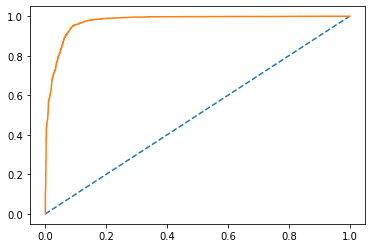

In [190]:
train_fpr, train_tpr, train_threshold = roc_curve(y,probs)
plt.plot([0,1],[0,1],Linestyle='--')
plt.plot(train_fpr,train_tpr)

In [191]:
#prediction
y_pred = lr.predict(x_test)

  
data1 = {'urlid':newTestBoilerPlate['urlid'],'label':y_pred}
    
submission_df =pd.DataFrame(data1)
    
submission_df.to_csv('submit.csv',index=False)

# Conclusion

1. Model Accuracy is about 92%.
2. Model is neither overfitter nor underfitted.
3. The Precision for Evergreen(1) is 0.94 and for Ephemeral(0) is 0.89
4. The Recall for Evergreen(1) is 0.90 and for Ephemeral(0) is 0.93
5. The ROC and AUC curve is 97.3%